In [51]:
import sys
import numpy as np
sys.path.append(r"C:\Users\Artem\Desktop\vs code project\SARIMA_for_git\src")
import matplotlib.pyplot as plt
import importlib
importlib.reload(importlib.import_module('utils'))
import utils as utils
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pickle

In [19]:
train, test, ex_tr, ex_test = utils.load_data()

Данные загружены!


In [20]:
utils.monitoring_callback.iteration = 1
model = SARIMAX(
    train,
    exog = ex_tr,
    order = (0,0,2),
    seasonal_order = (1,1,0,24),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(method='lbfgs', disp=True, maxiter=1000, callback=utils.monitoring_callback)  
print(results.summary())

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35


c:\Users\Artem\PycharmProjects\pythonProjectNaychka\.venv\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3016: RuntimeWarning: divide by zero encountered in divide
  return self.params / self.bse


                                      SARIMAX Results                                      
Dep. Variable:                   total load actual   No. Observations:                22752
Model:             SARIMAX(0, 0, 2)x(1, 1, [], 24)   Log Likelihood             -196033.601
Date:                             Sun, 28 Sep 2025   AIC                         392143.203
Time:                                     12:28:52   BIC                         392448.354
Sample:                                 10-03-2015   HQIC                        392242.429
                                      - 05-08-2018                                         
Covariance Type:                               opg                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     4.03e-07         -0       -inf      0.000    4.03e-07 

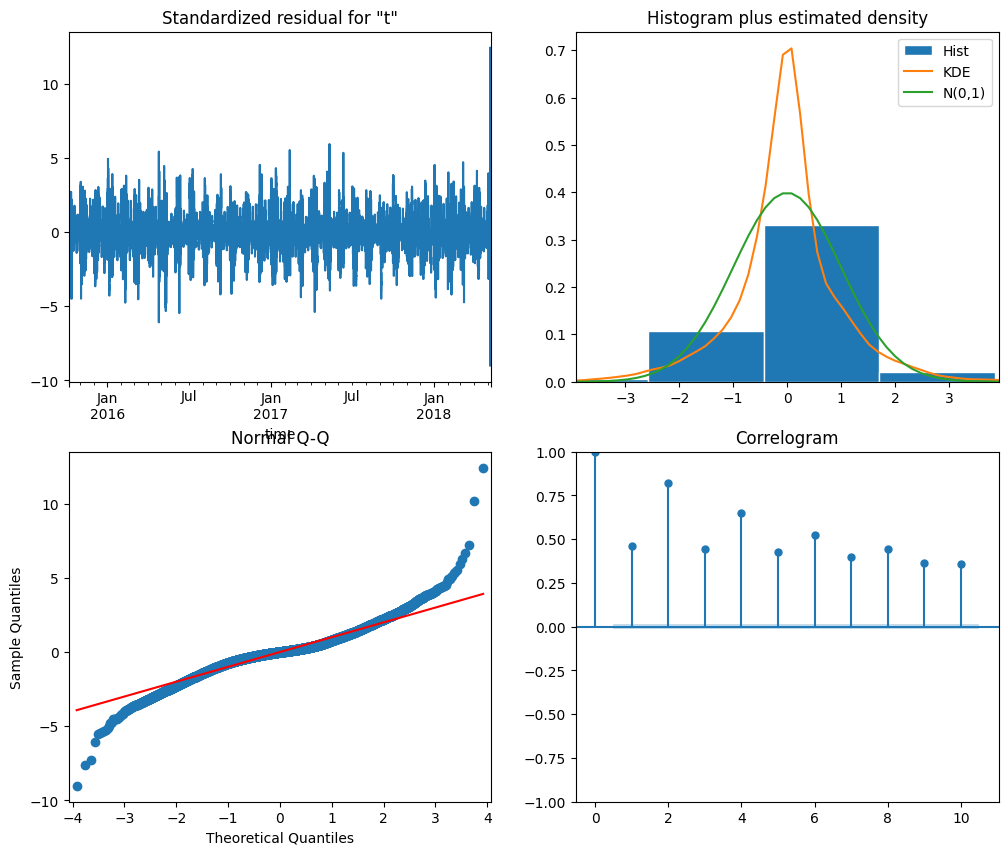

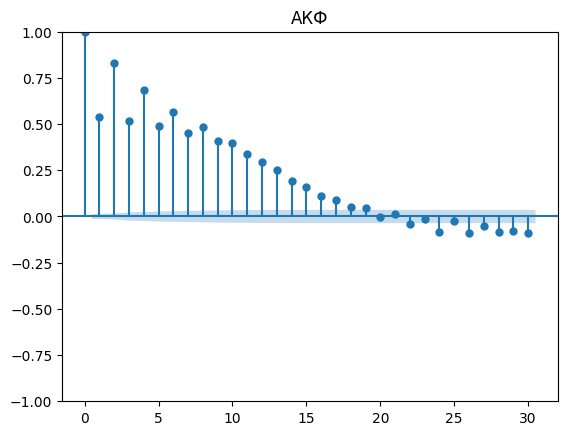

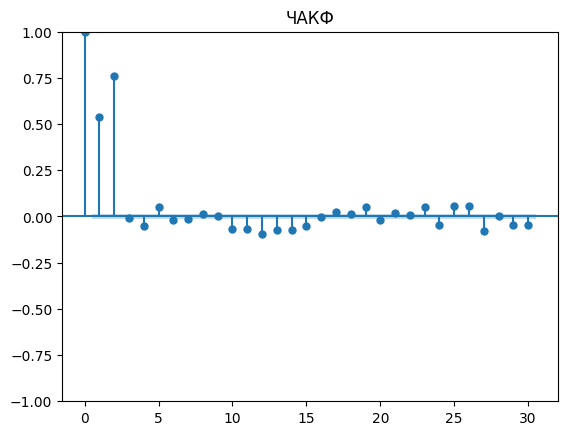

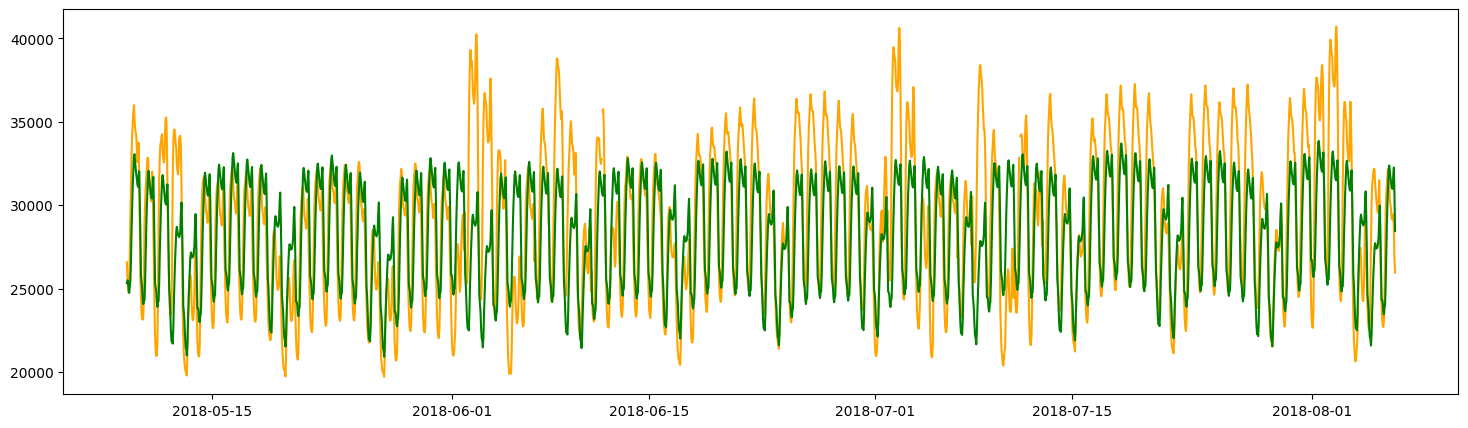

In [22]:
results.plot_diagnostics(figsize=(12,10))
plt.show()
utils.corralelogramm(results.resid)
# --- Прогноз ---
n_test = len(ex_test)
forecast = results.get_forecast(steps=n_test, exog=ex_test)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
# --- Визуализация ---
plt.figure(figsize=(18,5))
#plt.plot(train.index, train, label="Train")
plt.plot(test[:24*90].index, test[:24*90], label="Исходный ряд", color="orange")
plt.plot(test[:24*90].index, forecast_mean[:24*90], label="Прогноз", color="green")

In [23]:
#results.save(r'..\models\sarimax_model1.pkl')
results.remove_data()  # Удаляет тяжелые массивы
results.save('../models/sarimax_model_clean1.pkl')

In [52]:
train_shape = len(train)
lens = utils.save_sarimax_compact(results, '../models/sarimax_model_clean2.pkl', train)
lens


Сохранено: ../models/sarimax_model_clean2.pkl


In [42]:
def load_sarimax_compact(filepath):
    with open(filepath, "rb") as f:
        data = pickle.load(f)

    def make_forecast(steps, exog=None):
        # Воссоздаём "хвост" ряда для корректных лагов
        y_init = np.array(data["train_tail"] + [0]*steps)

        temp_model = SARIMAX(
            y_init,
            exog=exog,
            order=data["order"],
            seasonal_order=data["seasonal_order"],
            enforce_stationarity=data["enforce_stationarity"],
            enforce_invertibility=data["enforce_invertibility"],
        )
        temp_results = temp_model.smooth(data["params"])
        forecast = temp_results.get_forecast(steps=steps, exog=exog)
        return forecast.predicted_mean, forecast.conf_int()

    return make_forecast

In [43]:
function_forecast =  load_sarimax_compact('../models/sarimax_model_clean2.pkl')
make_forecast = function_forecast(24)

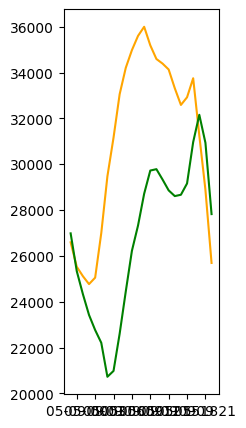

In [50]:
make_forecast_forecast_mean, make_forecast_forecast_ci = make_forecast
#--- Визуализация ---
plt.figure(figsize=(2,5))
#plt.plot(train.index, train, label="Train")
plt.plot(test[:24].index, test[:24], label="Исходный ряд", color="orange")
plt.plot(test[:24].index, make_forecast_forecast_mean[:24], label="Прогноз", color="green")

Метрика MAE: 3360.7079492238954


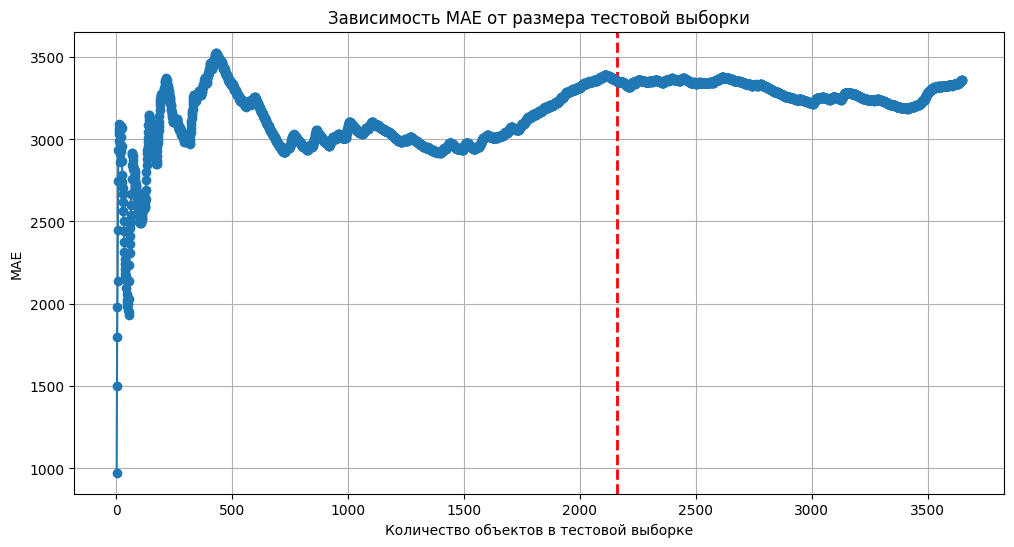

Метрика R2_score: 0.15446013245534207


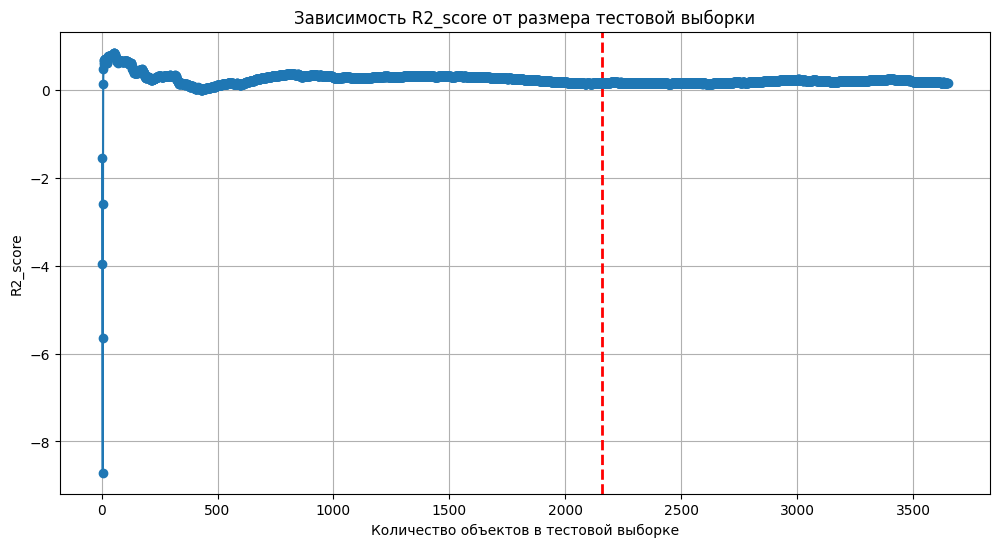

Метрика MAPE: 0.1212525991721416


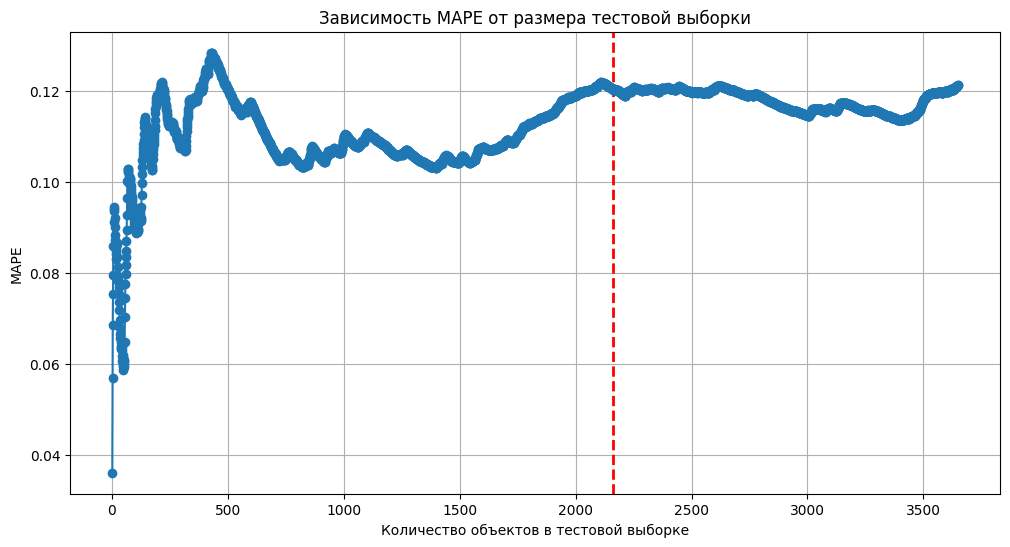

In [18]:
mae, r2_score, mape = utils.metrics(test, forecast_mean)